<a class="anchor" id="0"></a>

# **SARIMA Model for Time Series Forecasting: COVID-19 Confirmed Cases in Canada**

**Author:** Stephen Prudente  
**Start Date:** 20th January, 2021

**Purpose:** The objective of this notebook is to explore using SARIMA Time Series Forecasting on a COVID-19 dataset from the Canadian Government open datasets repository to predict COVID-19 positive cases. SARIMA (Seasonal Autoregressive Integrated Moving Average)

## Table of contents
1. [Importing Libraries](#Import-Libraries)
2. [Read Data](#read-data)
3. [Data Preperation](#data-preperation)
4. [Data Visualizations](#data-visualizations)  
5. [Feature Engineering](#feature-engineering)
6. [Training The Data](#training-the-data)
7. [Modeling The Data](#modelling-the-data-a-class)
8. [Future Predictions](#future-predictions)

## Importing Libraries  <a name="log"></a>

In [36]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import pmdarima as pm
from pmdarima.model_selection import train_test_split
from pmdarima.arima import auto_arima
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from matplotlib.pylab import rcParams
import matplotlib.pyplot as plt
import itertools
import warnings
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_log_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
plt.style.use('ggplot')
%matplotlib inline

- Now, we will import the CSV file from a Url and show the top 5 rows of the dataset. Create categories for each Province. Canada first to ensure it works.

# Read Data  <a name="log"></a>

- Importing the csv file via Url and etting the 'date' column as the index

In [41]:
df = pd.read_csv (r'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv')
print ('Shape of data', df.shape)
df.head()

Shape of data (11172, 40)


,pruid,prname,prnameFR,date,update,numconf,numprob,numdeaths,numtotal,numtested,...,ratedeaths_last14,numtotal_last7,ratetotal_last7,numdeaths_last7,ratedeaths_last7,avgtotal_last7,avgincidence_last7,avgdeaths_last7,avgratedeaths_last7,raterecovered
0,35,Ontario,Ontario,2020-01-31,NaN,3,0.0,0,3,0.0,...,0.0,0,0.00,0,0.0,0.00,0.00,0.0,0.0,0.0
1,59,British Columbia,Colombie-Britannique,2020-01-31,NaN,1,0.0,0,1,0.0,...,0.0,0,0.00,0,0.0,0.00,0.00,0.0,0.0,0.0
2,1,Canada,Canada,2020-01-31,NaN,4,0.0,0,4,0.0,...,0.0,0,0.00,0,0.0,0.00,0.00,0.0,0.0,0.0
3,35,Ontario,Ontario,2020-02-08,NaN,3,0.0,0,3,0.0,...,0.0,0,0.00,0,0.0,0.00,0.00,0.0,0.0,0.0
4,59,British Columbia,Colombie-Britannique,2020-02-08,NaN,4,0.0,0,4,0.0,...,0.0,3,0.06,0,0.0,0.43,0.01,0.0,0.0,0.0


In [ ]:
df_index = pd.read_csv (r'https://health-infobase.canada.ca/src/data/covidLive/covid19-download.csv')
df_index.set_index("date",inplace=True)
print ('Shape of data', df_index.shape)
df_index.head()

In [42]:
correlation = df.corr()

In [43]:
df = df[df['prname'].str.contains('Canada')]
print(df)

       pruid  prname prnameFR        date  update  numconf  numprob  \
2          1  Canada   Canada  2020-01-31     NaN        4      0.0   
5          1  Canada   Canada  2020-02-08     NaN        7      0.0   
8          1  Canada   Canada  2020-02-16     NaN        8      0.0   
11         1  Canada   Canada  2020-02-21     NaN        9      0.0   
14         1  Canada   Canada  2020-02-24     NaN       10      0.0   
...      ...     ...      ...         ...     ...      ...      ...   
11111      1  Canada   Canada  2022-03-17     NaN  3388551      NaN   
11126      1  Canada   Canada  2022-03-18     NaN  3393835      NaN   
11141      1  Canada   Canada  2022-03-19     NaN  3396562      NaN   
11156      1  Canada   Canada  2022-03-20     NaN  3401486      NaN   
11171      1  Canada   Canada  2022-03-21     NaN  3404283      NaN   

       numdeaths  numtotal  numtested  ...  ratedeaths_last14  numtotal_last7  \
2              0         4        0.0  ...               0.00     

- Gives a boolean value if any null value is present or not, it gives results column-wise format

In [ ]:
df.isna().any()

- Remove duplicates

In [ ]:
df.duplicated()

# Data Preperation  <a name="log"></a>

- Either focus solely on Canada by removing other Provinces or break apart each province into a dataset to remove 'date' duplicates

- Creating a data subset that will be used in the modeling containing the following columns: 'prname' (Province Name) & 'numconf' (Number Confirmed)

In [50]:
df_Canada = df[['date','prname','numteststoday']]
print(df_Canada)

             date  prname  numteststoday
2      2020-01-31  Canada              0
5      2020-02-08  Canada             63
8      2020-02-16  Canada             46
11     2020-02-21  Canada             57
14     2020-02-24  Canada             46
...           ...     ...            ...
11111  2022-03-17  Canada          49051
11126  2022-03-18  Canada          43149
11141  2022-03-19  Canada          28378
11156  2022-03-20  Canada           2945
11171  2022-03-21  Canada          76418

[757 rows x 3 columns]


<AxesSubplot:>

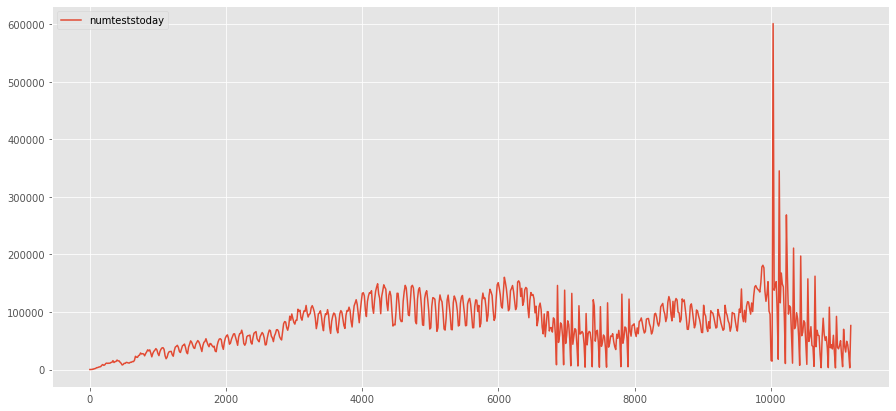

In [51]:
from pylab import rcParams
rcParams['figure.figsize'] = 15, 7
df_Canada.plot()

In [52]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(ts_month_avg, model='additive')
fig = decomposition.plot()
plt.show()

NameError: name 'ts_month_avg' is not defined

- Descriptive Statistics

In [ ]:
df_Canada.describe()

- Checking the dataset for null values before proceeding with the analysis.

In [ ]:
df_Canada.isnull().sum()

- Performing a correlation on the dataset.

In [ ]:
df_Canada.corr()

# Data Visualizations  <a name="log"></a>

- Line graph from the dataset using the numconf (Number Confirmed) and the date (Index).

<AxesSubplot:>

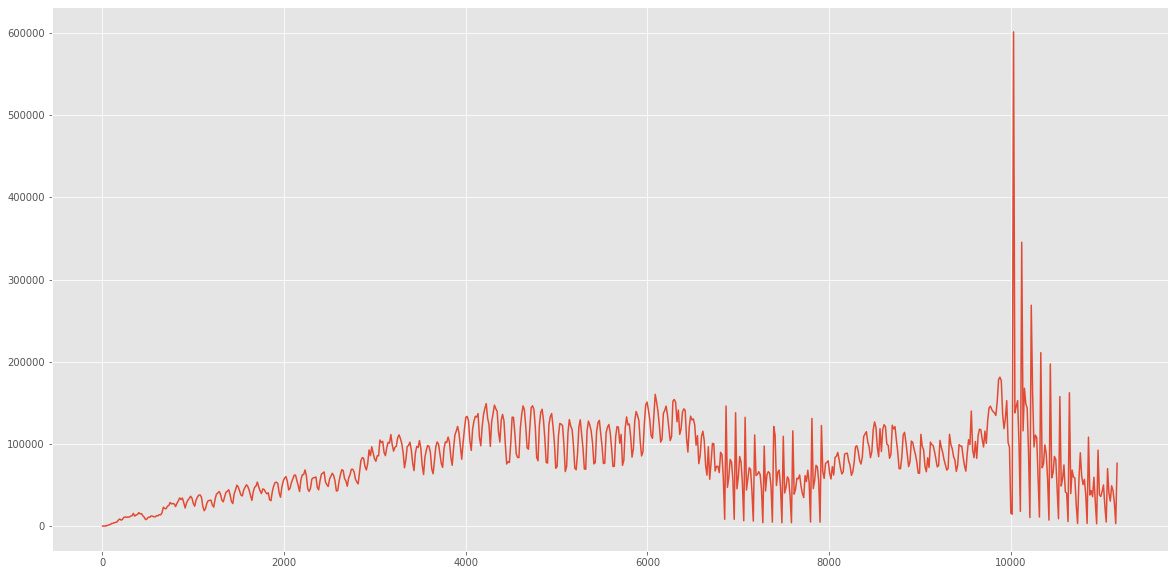

In [53]:
df['numteststoday'].plot(figsize=(20,10))

In [54]:
best_model = SARIMAX(df_Canada['numteststoday'], order=(2, 1, 2), seasonal_order=(2, 1, 2, 12)).fit(dis=-1)
print(best_model.summary())

                                     SARIMAX Results                                      
Dep. Variable:                      numteststoday   No. Observations:                  757
Model:             SARIMAX(2, 1, 2)x(2, 1, 2, 12)   Log Likelihood               -8875.901
Date:                            Wed, 23 Mar 2022   AIC                          17769.802
Time:                                    00:27:45   BIC                          17811.311
Sample:                                         0   HQIC                         17785.802
                                            - 757                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7738      0.102      7.615      0.000       0.575       0.973
ar.L2         -0.0492      0.108   

- Diagnosing the model residuals


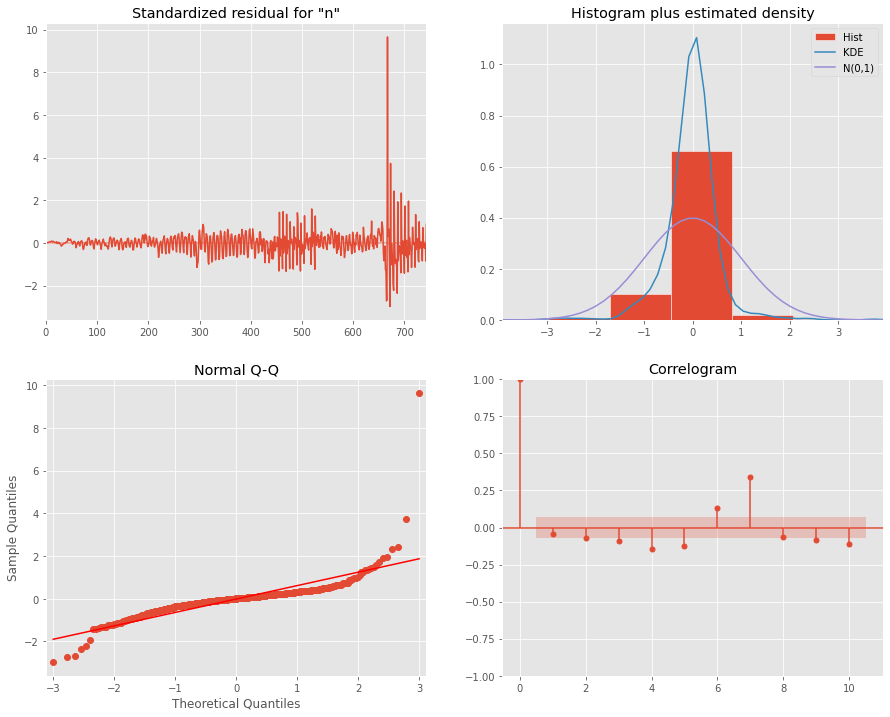

In [55]:
best_model.plot_diagnostics(figsize=(15,12));


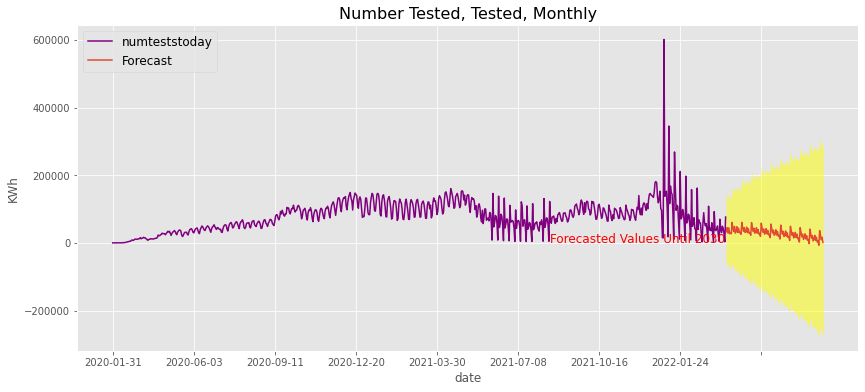

In [56]:
#Forecasting 10 years ahead
forecast_values = best_model.get_forecast(steps = 120)

#Confidence intervals of the forecasted values
forecast_ci = forecast_values.conf_int()

#Plot the data
ax = df_Canada.plot(x='date', y='numteststoday', figsize = (14, 6), legend = True, color='purple')

#Plot the forecasted values 
forecast_values.predicted_mean.plot(ax=ax, label='Forecast', figsize = (14, 6), grid=True)

#Plot the confidence intervals
ax.fill_between(forecast_ci.index,
                forecast_ci.iloc[: , 0],
                forecast_ci.iloc[: , 1], color='yellow', alpha = .5)
plt.title('Number Tested, Tested, Monthly', size = 16)
plt.ylabel('KWh', size=12)
plt.legend(loc='upper left', prop={'size': 12})
ax.axes.get_xaxis().set_visible(True)
#annotation
ax.text(540, 400, 'Forecasted Values Until 2030', fontsize=12,  color='red')
plt.show()

In [ ]:
#divide into train and validation set to calculate R-squared score and mean absolute percentage error 
train = data[:int(0.85*(len(data)))]
test = data[int(0.85*(len(data))):]
start=len(train)
end=len(train)+len(test)-1
predictions = best_model.predict(start=start, end=end, dynamic=False, typ='levels').rename('SARIMA Predictions')
evaluation_results = pd.DataFrame({'r2_score': r2_score(test['Electricity'], predictions)}, index=[0])
evaluation_results['mean_absolute_error'] = mean_absolute_error(test['Electricity'], predictions)
evaluation_results['mean_squared_error'] = mean_squared_error(test['Electricity'], predictions)
evaluation_results['root_mean_squared_error'] = np.sqrt(mean_squared_error(test['Electricity'], predictions))
evaluation_results['mean_absolute_percentage_error'] = np.mean(np.abs(predictions - test['Electricity'])
                                                               /np.abs(test['Electricity']))*100 
evaluation_results

# Feature Engineering  <a name="log"></a>

In [12]:
from statsmodels.tsa.stattools import adfuller

In [13]:
test_result=adfuller(df_Canada['numteststoday'])

In [16]:
from statsmodels.tsa.stattools import adfuller

def ad_test(df_Canada):
     dftest = adfuller(df_Canada, autolag = 'AIC')
     print("1. ADF : ",dftest[0])
     print("2. P-Value : ", dftest[1])
     print("3. Num Of Lags : ", dftest[2])
     print("4. Num Of Observations Used For ADF Regression and Critical Value Calculation :",      dftest[3])
     print("5. Critical Values :")
     for key, val in dftest[4].items():
         print("\t",key, ": ", val)

- first difference and seasonal difference

In [17]:
df_Canada['numteststoday First Difference'] = df_Canada['numteststoday'] - df_Canada['numteststoday'].shift(1)
df_Canada['Seasonal First Difference']=df_Canada['numteststoday']-df_Canada['numteststoday'].shift(12)
df_Canada.head()

C:\Users\prude\AppData\Local\Temp\ipykernel_31812\3249552013.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Canada['numteststoday First Difference'] = df_Canada['numteststoday'] - df_Canada['numteststoday'].shift(1)
C:\Users\prude\AppData\Local\Temp\ipykernel_31812\3249552013.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Canada['Seasonal First Difference']=df_Canada['numteststoday']-df_Canada['numteststoday'].shift(12)


,prname,numteststoday,numteststoday First Difference,Seasonal First Difference
date,,,,
2020-01-31,Canada,0,NaN,NaN
2020-02-08,Canada,63,63.0,NaN
2020-02-16,Canada,46,-17.0,NaN
2020-02-21,Canada,57,11.0,NaN
2020-02-24,Canada,46,-11.0,NaN


- Again testing if data is stationary

In [18]:
adfuller_test(df_Canada['Seasonal First Difference'].dropna())

ADF Test Statistic : date
2020-03-06      296.0
2020-03-07      309.0
2020-03-08      886.0
2020-03-09      775.0
2020-03-11     1269.0
               ...   
2022-03-17    19855.0
2022-03-18    40299.0
2022-03-19   -63963.0
2022-03-20   -35464.0
2022-03-21    40415.0
Name: Seasonal First Difference, Length: 745, dtype: float64
p-value : date
2020-03-06      296.0
2020-03-07      309.0
2020-03-08      886.0
2020-03-09      775.0
2020-03-11     1269.0
               ...   
2022-03-17    19855.0
2022-03-18    40299.0
2022-03-19   -63963.0
2022-03-20   -35464.0
2022-03-21    40415.0
Name: Seasonal First Difference, Length: 745, dtype: float64
#Lags Used : date
2020-03-06      296.0
2020-03-07      309.0
2020-03-08      886.0
2020-03-09      775.0
2020-03-11     1269.0
               ...   
2022-03-17    19855.0
2022-03-18    40299.0
2022-03-19   -63963.0
2022-03-20   -35464.0
2022-03-21    40415.0
Name: Seasonal First Difference, Length: 745, dtype: float64
Number of Observations : date
20

- Data is stationary

<AxesSubplot:xlabel='date'>

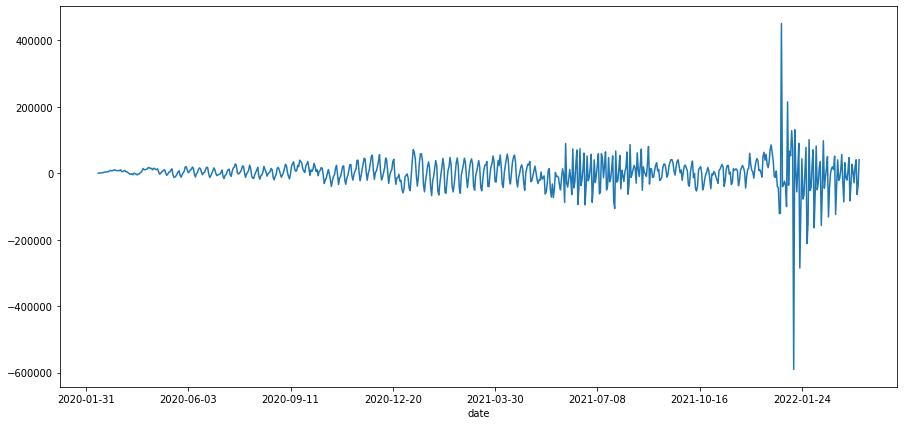

In [19]:
df_Canada['Seasonal First Difference'].plot()

- auto-correlation

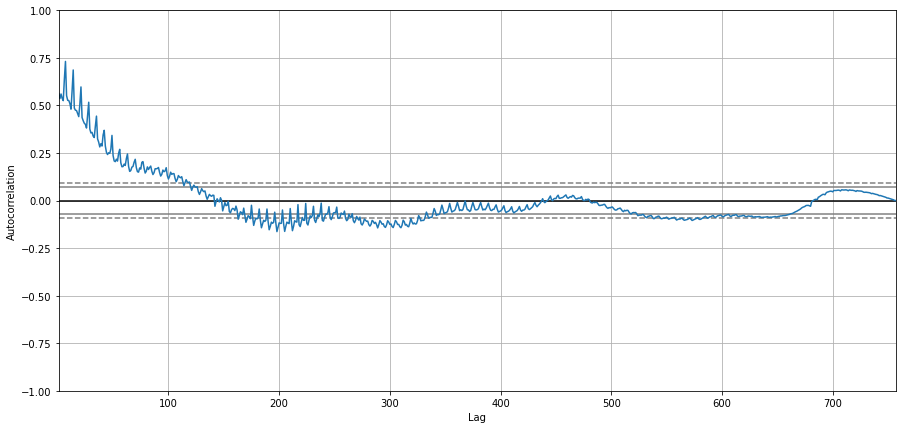

In [20]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(df_Canada['numteststoday'])
plt.show()

c:\Users\prude\OneDrive\Desktop\Project\venv\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


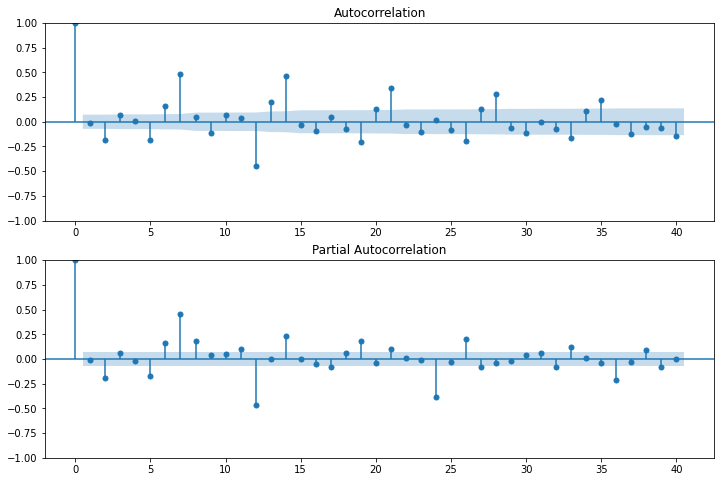

In [21]:
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf
import statsmodels.api as sm
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df_Canada['Seasonal First Difference'].dropna(),lags=40,ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df_Canada['Seasonal First Difference'].dropna(),lags=40,ax=ax2)

- For non-seasonal data
#p=1, d=1, q=0 or 1


In [24]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [26]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
from statsmodels.tsa.arima_model import ARIMA

arima_model=ARIMA(df_Canada['numteststoday'],order=(5,1,2))
model_fit=arima_model.fit()
model_fit.summary()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


In [23]:
df_Canada['forecast']=model_fit.predict(start=90,end=103,dynamic=True)
df_Canada[['numteststoday','forecast']].plot(figsize=(12,8))

NameError: name 'model_fit' is not defined

- Determining if the p-value is greater than the significance level (0.05).

In [ ]:
ad_test(df['numteststoday'])

In [ ]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
plt.rcParams.update({'figure.figsize':(9,7), 'figure.dpi':120})


# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(df_Canada.numteststoday); axes[0, 0].set_title('Original Series')
plot_acf(df_Canada.numteststoday, ax=axes[0, 1])

# 1st Differencing
axes[1, 0].plot(df_Canada.numteststoday.diff()); axes[1, 0].set_title('1st Order Differencing')
plot_acf(df_Canada.numteststoday.diff().dropna(), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(df_Canada.numteststoday.diff().diff()); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(df_Canada.numteststoday.diff().diff().dropna(), ax=axes[2, 1])

plt.show()

- Figure Out Order for ARIMA Model.

In [ ]:
from pmdarima.arima import auto_arima
# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")

- Enter the variable in the ' ' below that will be forecasted.

In [29]:
stepwise_fit = auto_arima(df_Canada['numteststoday'], trace=True,
                          suppress_warnings=True)

stepwise_fit.summary()

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=17762.388, Time=0.31 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=18299.879, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=18110.521, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=17840.425, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=18297.884, Time=0.01 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=17840.068, Time=0.10 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=17829.934, Time=0.10 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=17753.664, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=17826.305, Time=0.14 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=17720.048, Time=0.44 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=17803.101, Time=0.16 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=17650.816, Time=0.49 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=17715.332, Time=0.24 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=17653.065, Time=0.57 sec
 ARIMA(4,1,3)(0,0,0

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  757
Model:               SARIMAX(5, 1, 2)   Log Likelihood               -8816.390
Date:                Wed, 23 Mar 2022   AIC                          17648.779
Time:                        00:09:59   BIC                          17685.804
Sample:                             0   HQIC                         17663.040
                                - 757                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0351      0.030     -1.185      0.236      -0.093       0.023
ar.L2         -0.4554      0.021    -21.693      0.000      -0.496      -0.414
ar.L3         -0.3654      0.033    -10.998      0.000      -0.431      -0.300
ar.L4         -0.3797      0.036    -10.667      0.000      -0.449      -0.310
ar.L5         -0.3929      0.030    -13.034      0.000      -0.452      -0.334
ma.L1         -1.0360      0.028    -36.504      0.000      -1.092      -0.980
ma.L2          0.5032      0.025     20.079      0.000       0.454       0.552
sigma2      7.756e+08   4.24e-11   1.83e+19      0.000    7.76e+08    7.76e+08
===================================================================================
Ljung-Box (L1) (Q):                   0.70   Jarque-Bera (JB):            445547.41
Prob(Q):                              0.40   Prob(JB):                         0.00
Heteroskedasticity (H):              45.98   Skew:                             5.90
Prob(H) (two-sided):                  0.00   Kurtosis:                       121.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.31e+33. Standard errors may be unstable.
"""

In [30]:
from statsmodels.tsa.arima_model import ARIMA

# Training The Data  <a name="log"></a>

- Split Data into Training and Testing.

In [31]:
print(df_Canada.shape)
train=df_Canada.iloc[:-30]
test=df_Canada.iloc[-30:]
print(train.shape,test.shape)

(757, 4)
(727, 4) (30, 4)


- Train the Model.

In [32]:
model=ARIMA(train["numteststoday"],order=(5,1,2))
model=model.fit()
model.summary()

NotImplementedError: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been removed in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and statsmodels.tsa.SARIMAX.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained. It also offers alternative specialized
parameter estimators.


- Make Predictions on Test Set.

In [ ]:
start=len(train)
end=len(train)+len(test)-1
pred=model.predict(start=start,end=end,typ='levels')
print(pred)
#pred.index=df.index[start:end+1]
#print(pred)

In [ ]:
pred.plot(legend=True)
test['numteststoday'].plot(legend=True)

In [ ]:
test['numteststoday'].mean()

In [ ]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(pred,test['numteststoday']))
print(rmse)

# Modelling The Data  <a name="log"></a>

In [ ]:
model2=ARIMA(df_Canada['numteststoday'],order=(1,0,5))
model2=model2.fit()
df.tail()

# Future Predictions  <a name="log"></a>

In [ ]:
index_future_dates=pd.date_range(starts='',end='')
#print(index_future_dates)
pred=model2.predict(start=len(df_Canada),end=len(df)+30,typ='levels').rename('ARIMA Predictions')
#print(comp_pred)
pred.index=index_future_dates
#print(comp_pred)

In [ ]:
pred.plot(figsize=(12,5),legend=True)